# **Computer Vision Assignment 4**

### **2. Scene Recognition using Bag of Visual Words (BOVW)**

In [ ]:
# Installing required versions
! pip install opencv-python==3.4.2.17
! pip install opencv-contrib-python==3.4.2.17

In [ ]:
# Import libraries
import cv2, glob, random
import numpy as np
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# Loading images
def loadImages(folder):
  ret = {}
  for filename in glob.glob(folder + '/*'):
    images = []
    for cat in glob.glob(filename + '/*'):
      img = cv2.imread(cat, 0)
      images.append(img)
    ret[filename.split('/')[-1]] = images
  return ret

In [ ]:
train = loadImages('../dataset/SUN_data/train')
test = loadImages("../dataset/SUN_data/test")

In [ ]:
# Get SIFT descriptors
def getFeatures(imgs):
  vectsSIFT, descriptors = {}, []
  sift = cv2.xfeatures2d.SIFT_create()
  for key, value in imgs.items():
    vectsSIFT[key] = getFeaturesHelper(sift, value, descriptors)
  return descriptors, vectsSIFT

def getFeaturesHelper(sift, x, descriptors):
  features = []
  for img in x:
    getDescriptor(sift, img, descriptors, features)
  return features

def getDescriptor(sift, img, descriptors, features):
  _, descriptor = sift.detectAndCompute(img, None)
  descriptors.extend(descriptor)
  features.append(descriptor)

descriptors, bovwAll_f = getFeatures(train)
bovwTest_f = getFeatures(test)[1] 

In [ ]:
# kmeans clustering with 20 clusters
kmeans = KMeans(n_clusters = 20, n_init=5, max_iter=50, verbose=1)
kmeans.fit(descriptors)
visual_words = kmeans.cluster_centers_

In [ ]:
# Find centroid
def getIndex(img, c):
  cnt, idx = 0, 0
  for i in range(len(c)):
    if i:
      d = euclidean(img, c[i]) 
      if d < cnt:
        idx = i
        cnt = d
    else:
      cnt = euclidean(img, c[i]) 
  return idx

In [ ]:
# create histogram
def createHist(bovw, c):
    dictionaryFeature = {}
    for key, value in bovw.items():
        dictionaryFeature[key] = getHisto(value, c)
    return dictionaryFeature

def getHisto(x, c):
  label = []
  for img in x:
    hist = np.zeros(len(c))
    updateHisto(img, c, hist)
    label.append(hist)
  return label

def updateHisto(img, c, hist):
  for f in img:
    idx = getIndex(f, c)
    hist[idx] += 1

In [ ]:
# Creates histograms for train and test data
bovwTrain = createHist(bovwAll_f, visual_words)
bovwTest = createHist(bovwTest_f, visual_words)

In [ ]:
# Label to index mapper
label2idx = {}
for i, j in enumerate(bovwTrain.keys()):
  label2idx[j] = i

In [ ]:
# Index to label mapper
idx2label = {v: k for k, v in label2idx.items()}

In [ ]:
label2idx

{'aquarium': 6,
 'desert': 7,
 'highway': 5,
 'kitchen': 0,
 'laundromat': 1,
 'park': 4,
 'waterfall': 2,
 'windmill': 3}

In [ ]:
idx2label

{0: 'kitchen',
 1: 'laundromat',
 2: 'waterfall',
 3: 'windmill',
 4: 'park',
 5: 'highway',
 6: 'aquarium',
 7: 'desert'}

In [ ]:
# List of labels
labels = []
for i in range(8):
  labels.append(idx2label[i])

In [ ]:
# Make training data ready
X = []
y = []
for i in bovwTrain.keys():
  for j in bovwTrain[i]:
    X.append(j)
    y.append(label2idx[i])

X = np.array(X)
y = np.array(y)

In [ ]:
# One vs All Classifier
clf = OneVsRestClassifier(SVC()).fit(X, y)

In [ ]:
# Make testing data ready
X = []
y_g = []
for i in bovwTest.keys():
  for j in bovwTest[i]:
    X.append(j)
    y_g.append(label2idx[i])

X = np.array(X)
y_g = np.array(y_g)

y = clf.predict(X)

In [ ]:
# Find overall accuracy
accuracy_score(y_g, y)

0.48125

### Without normalizing

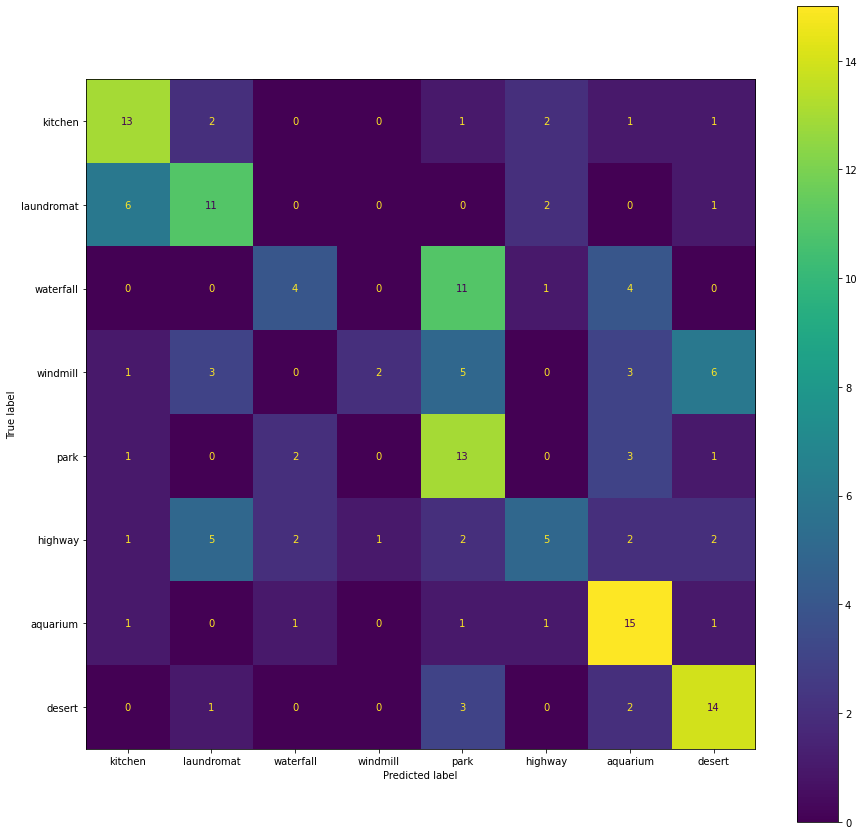

In [ ]:
# Plotting confusion matrix
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(clf, X, y_g, display_labels=labels, ax=ax)
plt.show()

### With normalizing

In [ ]:
# Function to normalize histogram
def normalizeHistos(histos):
  newHisto = {}
  for i in histos.keys():
    newHisto[i] = []
    for j in histos[i]:
      newHisto[i].append(j / np.sum(j))
  return newHisto

In [ ]:
bovwTrain = normalizeHistos(bovwTrain)
bovwTest = normalizeHistos(bovwTest)

In [ ]:
X = []
y = []
for i in bovwTrain.keys():
  for j in bovwTrain[i]:
    X.append(j)
    y.append(label2idx[i])

X = np.array(X)
y = np.array(y)

clf = OneVsRestClassifier(SVC()).fit(X, y)

X = []
y_g = []
for i in bovwTest.keys():
  for j in bovwTest[i]:
    X.append(j)
    y_g.append(label2idx[i])

X = np.array(X)
y_g = np.array(y_g)

y = clf.predict(X)

In [ ]:
accuracy_score(y_g, y)

0.5

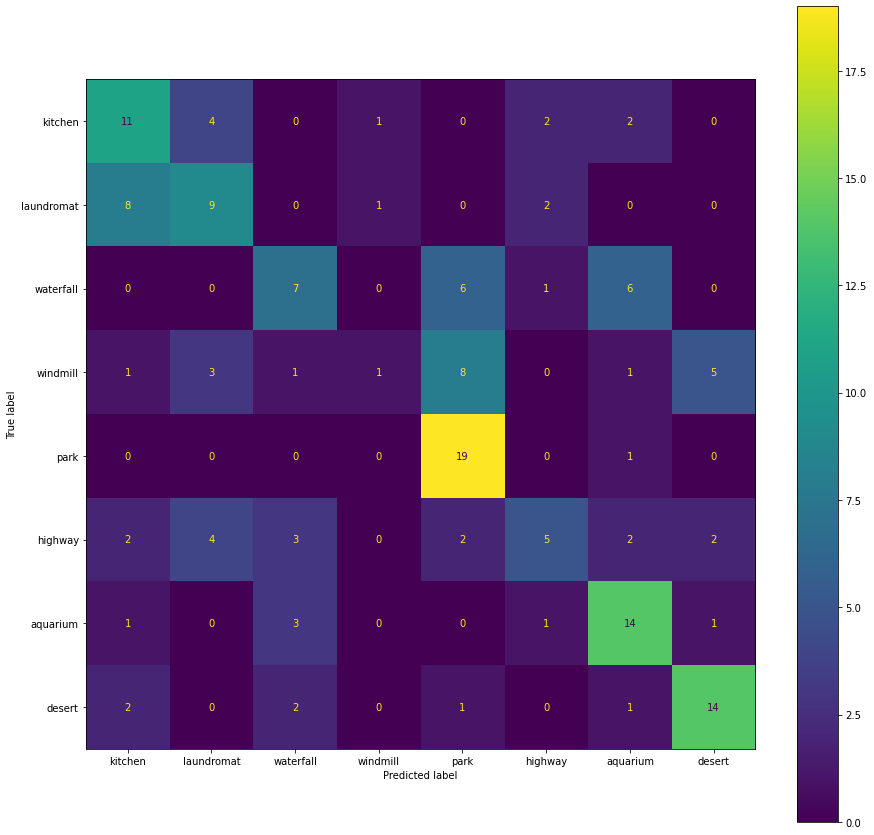

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(clf, X, y_g, display_labels=labels, ax=ax)
plt.show()

We can see that the accuracy has increased from 48.125% to 50% after normalizing the histograms.

Also the accuracy is actually great (50%) because I've just used 20 clusters with max iterations = 50. I've used these parameters due to the huge amount of time it takes to run otherwise.

In [ ]:
# Find correct an wrong classified images
correct = []
correctLabel = []
wrong = []
wrongLabel = []
curIndex = 0
for i in test.keys():
  for j in test[i]:
    if y_g[curIndex] == y[curIndex]:
      correct.append(j)
      correctLabel.append(idx2label[y[curIndex]])
    else:
      wrong.append(j)
      wrongLabel.append(idx2label[y[curIndex]])
    curIndex += 1

In [ ]:
# randomly shuffle images
c = list(zip(correct, correctLabel))
random.shuffle(c)
correct, correctLabel = zip(*c)

# Correct classifications

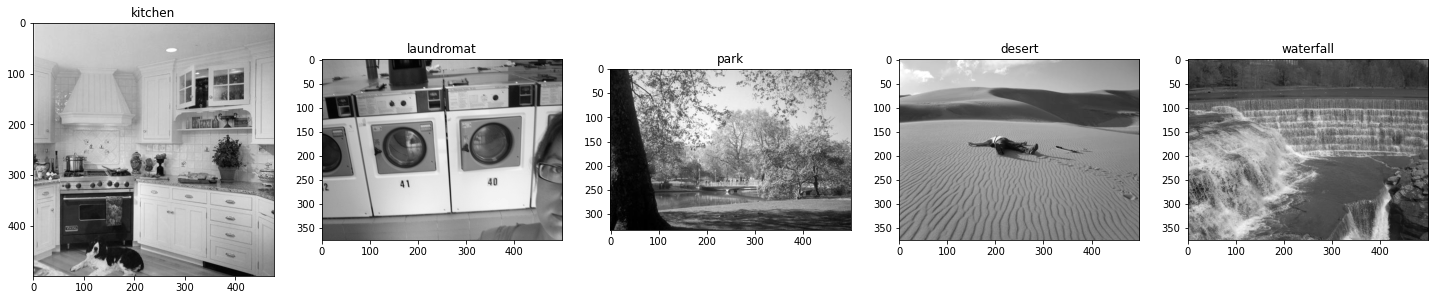

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(25, 15))
for i in range(5):
  ax[i].imshow(correct[i], cmap='gray')
  ax[i].set_title(correctLabel[i])

# Wrong classifications

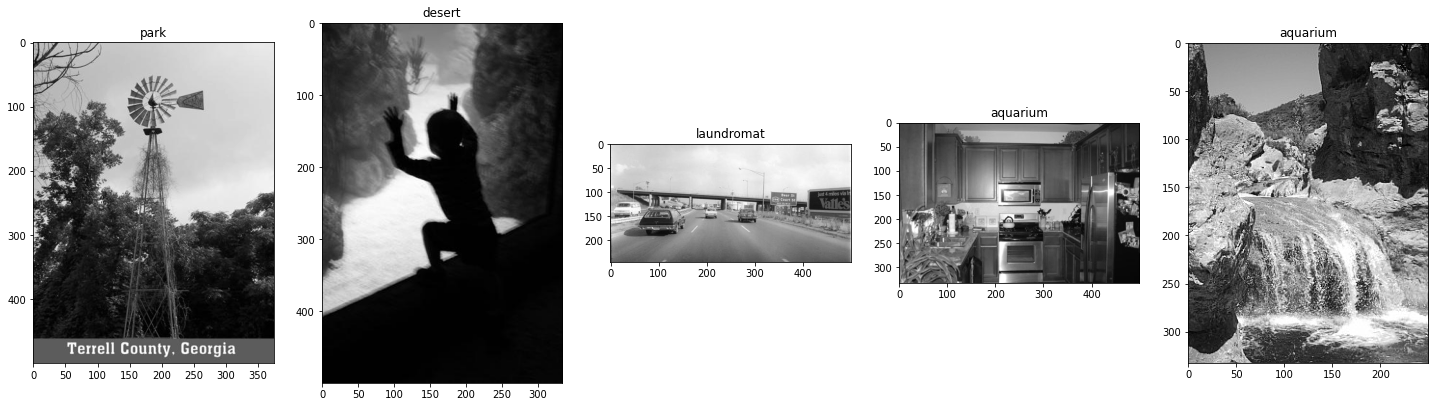

In [ ]:
c = list(zip(wrong, wrongLabel))
random.shuffle(c)
wrong, wrongLabel = zip(*c)

fig, ax = plt.subplots(1, 5, figsize=(25, 15))
for i in range(5):
  ax[i].imshow(wrong[i], cmap='gray')
  ax[i].set_title(wrongLabel[i])